<a href="https://colab.research.google.com/github/SajjadRahati1/Index/blob/main/RQA_NLP_triviaqa2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrieval Question-Answering of NLP

# Load Data

## Load from Json files

In [1]:
# connect to my drive for use dataset file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# load files dataset
import json
path_base = '/content/drive/MyDrive/Dataset/RQA/triviaqa-unfiltered/'
path_files = {
    'train' : f'{path_base}unfiltered-web-train.json',
    'dev' : f'{path_base}unfiltered-web-dev.json',
    'test' : f'{path_base}unfiltered-web-test-without-answers.json',
}


In [3]:
# !pip install ijson
# !pip install transformers
!pip install torch
!pip install torch torchvision torchaudio

## utils

In [2]:
def save_dataframe_to_csv(df, filename):

    try:
        df.to_csv(filename, index=False)
        print(f"DataFrame saved to {filename}")
    except Exception as e:
        print(f"An error occurred while saving the DataFrame: {e}")
def read_dataframe_from_csv(filename):

    try:
        df = pd.read_csv(filename)
        print(f"DataFrame read from {filename}")
        return df
    except Exception as e:
        print(f"An error occurred while reading the DataFrame: {e}")
        return None
def sample_dataframe(df, n, random_state=None):
    if n > len(df):
        raise ValueError("Sample size n cannot be greater than the number of rows in the DataFrame.")

    sampled_df = df.sample(n=n, random_state=random_state)
    return sampled_df

In [ ]:
import json
import ijson

def get_file_contents(filename, encoding='utf-8'):
    with open(filename, encoding=encoding) as f:
        content = f.read()
    return content

def get_file_contents_batch(filename, encoding='utf-8', batch_len=1000):
    # Initialize a dictionary to store the processed data
    contents = {'Data': [], 'Domain': None, 'VerifiedEval': False, 'Version': None}

    # Open the file and read it incrementally
    with open(filename, 'r', encoding=encoding) as file:
        # Read basic metadata keys first if necessary
        parser = ijson.parse(file)

        # Use a loop to gather metadata
        for prefix, event, value in parser:
            if (prefix, event) == ('Domain', 'string'):
                contents['Domain'] = value
            elif (prefix, event) == ('VerifiedEval', 'boolean'):
                contents['VerifiedEval'] = value
            elif (prefix, event) == ('Version', 'number'):
                contents['Version'] = value
            # Stop parsing metadata when 'Data' array is reached
            if prefix == 'Data':
                break

        # Reset file reading position to start reading 'Data'
        file.seek(0)

        # Use ijson to parse 'Data' array incrementally
        # data_items = ijson.items(file, 'Data.item')

        batch = []  # Temporary list to hold each batch
        test_index = 0
        for item in ijson.items(file, 'Data.item'):

            batch.append(item)

            # If batch reaches the specified length, add it to 'Data'
            if len(batch) >= batch_len:
                contents['Data'].extend(batch)
                batch.clear()

        # Add any remaining items in the batch to 'Data'
        if batch:
            contents['Data'].extend(batch)

    return contents
def read_json(filename, encoding='utf-8',use_batch = False):
    if use_batch:
      contents = get_file_contents_batch(filename, encoding=encoding)
    else:
      contents = get_file_contents(filename, encoding=encoding)
      contents = json.loads(contents)
    return contents



## dataset_utils

In [ ]:


def read_clean_part(datum):
    for key in ['EntityPages', 'SearchResults']:
        new_page_list = []
        for page in datum.get(key, []):
            if page['DocPartOfVerifiedEval']:
                new_page_list.append(page)
        datum[key] = new_page_list
    assert len(datum['EntityPages']) + len(datum['SearchResults']) > 0
    return datum


def read_triviaqa_data(qajson,use_batch = False):
    data = read_json(qajson,use_batch = use_batch)
    # read only documents and questions that are a part of clean data set
    if data['VerifiedEval']:
        clean_data = []
        for datum in data['Data']:
            if datum['QuestionPartOfVerifiedEval']:
                if data['Domain'] == 'Web':
                    datum = read_clean_part(datum)
                clean_data.append(datum)
        data['Data'] = clean_data
    return data


In [ ]:
dev_data = read_triviaqa_data(path_files['dev'])

In [ ]:
train_data = read_triviaqa_data(path_files['train'],True)

In [ ]:
test_data = read_triviaqa_data(path_files['test'])

In [3]:
import ast

def clean_and_create_context(search_results):
    try:
        # تبدیل رشته به لیست واقعی
        search_result_list = ast.literal_eval(search_results)
        # اتصال جملات با نقطه و فاصله
        context = '. '.join(search_result_list)
        return context
    except Exception as e:
        print(f"Error processing search_results: {e}")
        return ""


## Extract Relevant Data

In [ ]:
import pandas as pd

def convert_to_df(data: dict):
    # Initialize lists to store the extracted data
    questions = []
    question_ids = []
    question_sources = []
    answers = []
    normalized_values = []
    entity_pages = []
    search_results = []

    # Parse the JSON data
    for item in data['Data']:
        # Extract question details
        question = item.get('Question', '')
        question_id = item.get('QuestionId', '')
        question_source = item.get('QuestionSource', '')

        # Extract answer details
        answer_data = item.get('Answer', {})
        answer_value = answer_data.get('Value', '')
        normalized_value = answer_data.get('NormalizedValue', '')

        # Extract entity pages
        entity_page_titles = [page.get('Title', '') for page in item.get('EntityPages', [])]

        # Extract search results descriptions
        search_result_descriptions = [result.get('Description', '') for result in item.get('SearchResults', [])]

        # Append extracted data to lists
        questions.append(question)
        question_ids.append(question_id)
        question_sources.append(question_source)
        answers.append(answer_value)
        normalized_values.append(normalized_value)
        entity_pages.append(entity_page_titles)
        search_results.append(search_result_descriptions)

    # Create DataFrame
    df = pd.DataFrame({
        'question': questions,
        'question_id': question_ids,
        'question_source': question_sources,
        'answer': answers,
        'normalized_value': normalized_values,
        'entity_pages': entity_pages,
        'search_results': search_results
    })

    return df


In [ ]:
df_dev = convert_to_df(dev_data)
df_train = convert_to_df(train_data)
df_test = convert_to_df(test_data)

In [ ]:
df_train.head(2)

,question,question_id,question_source,answer,normalized_value,entity_pages,search_results
0,Who was President when the first Peanuts carto...,tc_0,http://www.triviacountry.com/,Harry Truman,harry truman,[Peanuts],"[Welcome to GoComics.com, the world's largest ..."
1,Which American-born Sinclair won the Nobel Pri...,tc_1,http://www.triviacountry.com/,Sinclair Lewis,sinclair lewis,[Nobel Prize in Literature],[The Nobel Prize in Literature 1930 Sinclair ....


In [ ]:
df_test.head(2)

,question,question_id,question_source,answer,normalized_value,entity_pages,search_results
0,Asmara international airport is in which country?,tc_7,http://www.triviacountry.com/,,,[Asmara International Airport],[Asmara International Airport (ASM/HAAY) safet...
1,At whose concert were 11 people trampled to de...,tc_37,http://www.triviacountry.com/,,,"[Ohio, The Who concert disaster]",[... — The 11 people who were trampled to deat...


## Preprocess the Text

In [4]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [ ]:
save_dataframe_to_csv(df_train,path_base + 'df_train.csv')

DataFrame saved to /content/drive/MyDrive/Dataset/RQA/triviaqa-unfiltered/df_train.csv


In [ ]:
save_dataframe_to_csv(df_test,path_base + 'df_test.csv')

DataFrame saved to /content/drive/MyDrive/Dataset/RQA/triviaqa-unfiltered/df_test.csv


In [ ]:
save_dataframe_to_csv(df_dev,path_base + 'df_dev.csv')

DataFrame saved to /content/drive/MyDrive/Dataset/RQA/triviaqa-unfiltered/df_dev.csv


In [6]:
try:
  df_train
except:
  df_train = read_dataframe_from_csv(path_base + 'df_train.csv')

DataFrame read from /content/drive/MyDrive/Dataset/RQA/triviaqa-unfiltered/df_train.csv


In [7]:
try:
  df_test
except:
  df_test = read_dataframe_from_csv(path_base + 'df_test.csv')

DataFrame read from /content/drive/MyDrive/Dataset/RQA/triviaqa-unfiltered/df_test.csv


In [8]:
try:
  df_dev
except:
  df_dev = read_dataframe_from_csv(path_base + 'df_dev.csv')

DataFrame read from /content/drive/MyDrive/Dataset/RQA/triviaqa-unfiltered/df_dev.csv


In [9]:
df_train = sample_dataframe(df_train, 5000, 42)


In [10]:
df_test = sample_dataframe(df_test, 1000, 42)
df_dev = sample_dataframe(df_dev, 1500, 42)

In [11]:
df_train['context'] = df_train.apply(lambda x: clean_and_create_context(x['search_results']), axis=1)
df_test['context'] = df_test.apply(lambda x: clean_and_create_context(x['search_results']), axis=1)
df_dev['context'] = df_dev.apply(lambda x: clean_and_create_context(x['search_results']), axis=1)

In [12]:
def preprocess_data(df_train, df_test, df_dev):
    # Initialize tokenizer
    tokenizer = Tokenizer()

    # Ensure all entries in 'question' and 'answer' columns are strings
    df_train['question'] = df_train['question'].astype(str).fillna('')
    df_test['question'] = df_test['question'].astype(str).fillna('')
    df_dev['question'] = df_dev['question'].astype(str).fillna('')

    df_train['answer'] = df_train['answer'].astype(str).fillna('')
    df_test['answer'] = df_test['answer'].astype(str).fillna('')
    df_dev['answer'] = df_dev['answer'].astype(str).fillna('')

    df_train['context'] = df_train['context'].astype(str).fillna('')
    df_test['context'] = df_test['context'].astype(str).fillna('')
    df_dev['context'] = df_dev['context'].astype(str).fillna('')

    # Tokenize the text in the DataFrame
    df_train['question_tokens'] = df_train['question'].apply(word_tokenize)
    df_test['question_tokens'] = df_test['question'].apply(word_tokenize)
    df_dev['question_tokens'] = df_dev['question'].apply(word_tokenize)

    df_train['answer_tokens'] = df_train['answer'].apply(word_tokenize)
    df_test['answer_tokens'] = df_test['answer'].apply(word_tokenize)
    df_dev['answer_tokens'] = df_dev['answer'].apply(word_tokenize)

    df_train['context_tokens'] = df_train['context'].apply(word_tokenize)
    df_test['context_tokens'] = df_test['context'].apply(word_tokenize)
    df_dev['context_tokens'] = df_dev['context'].apply(word_tokenize)

    # Additional preprocessing (lowercasing)
    df_train['question_tokens'] = df_train['question_tokens'].apply(lambda tokens: [token.lower() for token in tokens])
    df_test['question_tokens'] = df_test['question_tokens'].apply(lambda tokens: [token.lower() for token in tokens])
    df_dev['question_tokens'] = df_dev['question_tokens'].apply(lambda tokens: [token.lower() for token in tokens])

    df_train['answer_tokens'] = df_train['answer_tokens'].apply(lambda tokens: [token.lower() for token in tokens])
    df_test['answer_tokens'] = df_test['answer_tokens'].apply(lambda tokens: [token.lower() for token in tokens])
    df_dev['answer_tokens'] = df_dev['answer_tokens'].apply(lambda tokens: [token.lower() for token in tokens])

    df_train['context_tokens'] = df_train['context_tokens'].apply(lambda tokens: [token.lower() for token in tokens])
    df_test['context_tokens'] = df_test['context_tokens'].apply(lambda tokens: [token.lower() for token in tokens])
    df_dev['context_tokens'] = df_dev['context_tokens'].apply(lambda tokens: [token.lower() for token in tokens])

    # Combine all questions and answers for fitting the tokenizer
    all_texts = df_train['question_tokens'].tolist() + df_test['question_tokens'].tolist() + df_dev['question_tokens'].tolist()
    all_answers = df_train['answer_tokens'].tolist() + df_test['answer_tokens'].tolist() + df_dev['answer_tokens'].tolist()
    all_context = df_train['context_tokens'].tolist() + df_test['context_tokens'].tolist() + df_dev['context_tokens'].tolist()

    # Fit tokenizer on all questions and answers
    tokenizer.fit_on_texts(all_texts + all_answers)

    # Tokenize questions
    df_train['question_seq'] = tokenizer.texts_to_sequences(df_train['question_tokens'])
    df_test['question_seq'] = tokenizer.texts_to_sequences(df_test['question_tokens'])
    df_dev['question_seq'] = tokenizer.texts_to_sequences(df_dev['question_tokens'])

    # Tokenize answers
    df_train['answer_seq'] = tokenizer.texts_to_sequences(df_train['answer_tokens'])
    df_test['answer_seq'] = tokenizer.texts_to_sequences(df_test['answer_tokens'])
    df_dev['answer_seq'] = tokenizer.texts_to_sequences(df_dev['answer_tokens'])

    # Tokenize context
    df_train['context_seq'] = tokenizer.texts_to_sequences(df_train['context_tokens'])
    df_test['context_seq'] = tokenizer.texts_to_sequences(df_test['context_tokens'])
    df_dev['context_seq'] = tokenizer.texts_to_sequences(df_dev['context_tokens'])

    # Calculate max_question_length
    max_question_length_train = df_train['question_seq'].apply(len).max()
    max_question_length_test = df_test['question_seq'].apply(len).max()
    max_question_length_dev = df_dev['question_seq'].apply(len).max()

    max_question_length = max(max_question_length_train, max_question_length_test, max_question_length_dev)

    # Calculate max_answer_length
    max_answer_length_train = df_train['answer_seq'].apply(len).max()
    max_answer_length_test = df_test['answer_seq'].apply(len).max()
    max_answer_length_dev = df_dev['answer_seq'].apply(len).max()

    max_answer_length = max(max_answer_length_train, max_answer_length_test, max_answer_length_dev)

    # Calculate max_answer_length
    max_context_length_train = df_train['context_seq'].apply(len).max()
    max_context_length_test = df_test['context_seq'].apply(len).max()
    max_context_length_dev = df_dev['context_seq'].apply(len).max()

    max_answer_length = max(max_context_length_train, max_context_length_test, max_context_length_dev)

    # Padding sequences
    df_train['question_seq_padded'] = pad_sequences(df_train['question_seq'], maxlen=max_question_length, padding='post').tolist()
    df_test['question_seq_padded'] = pad_sequences(df_test['question_seq'], maxlen=max_question_length, padding='post').tolist()
    df_dev['question_seq_padded'] = pad_sequences(df_dev['question_seq'], maxlen=max_question_length, padding='post').tolist()

    df_train['answer_seq_padded'] = pad_sequences(df_train['answer_seq'], maxlen=max_answer_length, padding='post').tolist()
    df_test['answer_seq_padded'] = pad_sequences(df_test['answer_seq'], maxlen=max_answer_length, padding='post').tolist()
    df_dev['answer_seq_padded'] = pad_sequences(df_dev['answer_seq'], maxlen=max_answer_length, padding='post').tolist()


    df_train['context_seq_padded'] = pad_sequences(df_train['context_seq'], maxlen=max_answer_length, padding='post').tolist()
    df_test['context_seq_padded'] = pad_sequences(df_test['context_seq'], maxlen=max_answer_length, padding='post').tolist()
    df_dev['context_seq_padded'] = pad_sequences(df_dev['context_seq'], maxlen=max_answer_length, padding='post').tolist()

    # Prepare inputs
    X_train = [np.array(df_train['question_seq_padded'].tolist()),np.array(df_train['context_seq_padded'].tolist())]
    X_test = [np.array(df_test['question_seq_padded'].tolist()),np.array(df_test['context_seq_padded'].tolist())]
    X_dev = [np.array(df_dev['question_seq_padded'].tolist()),np.array(df_dev['context_seq_padded'].tolist())]

    # Assuming 'answer_start' as target variable (for RQA tasks)
    y_train = np.array(df_train['answer_seq_padded'].tolist())
    y_test = np.array(df_test['answer_seq_padded'].tolist())
    y_dev = np.array(df_dev['answer_seq_padded'].tolist())

    return X_train, X_test, X_dev, y_train, y_test, y_dev, tokenizer,max_question_length,max_answer_length

In [13]:
X_train, X_test, X_dev, y_train, y_test, y_dev, tokenizer, max_question_length, max_answer_length = preprocess_data(df_train, df_test, df_dev)


# Create model with LSTM

## New LSTM(T5)

In [17]:
!pip install evaluate

In [14]:
import torch
import json
from tqdm import tqdm
import torch.nn as nn
from torch.optim import Adam
import nltk
import spacy
import string
import evaluate  # Bleu
from torch.utils.data import Dataset, DataLoader, RandomSampler
import pandas as pd
import numpy as np
import transformers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration, T5TokenizerFast

import warnings

In [15]:

warnings.filterwarnings("ignore")

In [16]:
t5_tokenizer = T5TokenizerFast.from_pretrained("t5-base")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-base", return_dict=True)
optimizer_adam = Adam(t5_model.parameters(), lr=0.00001)


In [17]:
q_len = 64 #len(X_train[0])   # Question Length
t_len = 64 #len(X_test)    # Target Length
batch_size = 8
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [18]:
q_len

128

In [18]:
class QA_Dataset(Dataset):
    def __init__(self, tokenizer, dataframe, q_len, t_len):
        self.tokenizer = tokenizer
        self.q_len = q_len
        self.t_len = t_len
        self.data = dataframe.reset_index(drop=True)  # Reset index to ensure continuity
        self.questions = self.data["question"]
        self.context = self.data["context"]
        self.answer = self.data['answer']

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx]
        context = self.context[idx]
        answer = self.answer[idx]

        question_tokenized = self.tokenizer(question, context, max_length=self.q_len, padding="max_length",
                                                    truncation=True, pad_to_max_length=True, add_special_tokens=True)
        answer_tokenized = self.tokenizer(answer, max_length=self.t_len, padding="max_length",
                                          truncation=True, pad_to_max_length=True, add_special_tokens=True)

        labels = torch.tensor(answer_tokenized["input_ids"], dtype=torch.long)
        labels[labels == 0] = -100

        return {
            "input_ids": torch.tensor(question_tokenized["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(question_tokenized["attention_mask"], dtype=torch.long),
            "labels": labels,
            "decoder_attention_mask": torch.tensor(answer_tokenized["attention_mask"], dtype=torch.long)
        }

In [19]:
df_train_dev = pd.concat([df_train , df_dev])

In [20]:
train_sampler = RandomSampler(df_train.index)
val_sampler = RandomSampler(df_dev.index)

qa_dataset = QA_Dataset(t5_tokenizer, df_train_dev, q_len, t_len)

train_loader = DataLoader(qa_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(qa_dataset, batch_size=batch_size, sampler=val_sampler)

In [21]:
# Function to calculate accuracy
def calculate_accuracy(preds, labels):
    preds = np.argmax(preds, axis=2)  # Get the index of the max log-probability
    mask = (labels != -100)  # Ignore padding indices and calculate accuracy
    correct = (preds == labels) & mask
    accuracy = correct.sum() / mask.sum()
    return accuracy.item()

In [23]:
train_loss = 0
val_loss = 0
train_batch_count = 0
val_batch_count = 0

for epoch in range(1):
    t5_model.train()
    train_loss = 0
    train_accuracy = 0
    train_batch_count = 0
    for batch in tqdm(train_loader, desc="Training batches"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        decoder_attention_mask = batch["decoder_attention_mask"].to(device)

        outputs = t5_model(
                          input_ids=input_ids,
                          attention_mask=attention_mask,
                          labels=labels,
                          decoder_attention_mask=decoder_attention_mask
                        )

        optimizer_adam.zero_grad()
        outputs.loss.backward()
        optimizer_adam.step()
        train_loss += outputs.loss.item()
        train_accuracy += calculate_accuracy(outputs.logits.detach().cpu().numpy(), labels.detach().cpu().numpy())
        train_batch_count += 1
    # Evaluation
    t5_model.eval()
    val_loss = 0
    val_accuracy = 0
    val_batch_count = 0

    for batch in tqdm(val_loader, desc="Validation batches"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        decoder_attention_mask = batch["decoder_attention_mask"].to(device)

        outputs = t5_model(
                          input_ids=input_ids,
                          attention_mask=attention_mask,
                          labels=labels,
                          decoder_attention_mask=decoder_attention_mask
                        )

        optimizer_adam.zero_grad()
        outputs.loss.backward()
        optimizer_adam.step()
        val_loss += outputs.loss.item()
        val_accuracy += calculate_accuracy(outputs.logits.detach().cpu().numpy(), labels.detach().cpu().numpy())
        val_batch_count += 1

    # Print results
    print(f"Epoch {epoch+1}/5 -> Train loss: {train_loss / train_batch_count:.4f}, Train accuracy: {train_accuracy / train_batch_count:.4f}")
    print(f"Validation loss: {val_loss / val_batch_count:.4f}, Validation accuracy: {val_accuracy / val_batch_count:.4f}")


Validation batches: 100%|██████████| 188/188 [44:06<00:00, 14.08s/it]

Epoch 1/5 -> Train loss: 3.0915, Train accuracy: 0.4754
Validation loss: 2.5999, Validation accuracy: 0.5438


In [25]:
t5_model.save_pretrained(path_base + "qa_model")
t5_tokenizer.save_pretrained(path_base + "qa_tokenizer")


('/content/drive/MyDrive/Dataset/RQA/triviaqa-unfiltered/qa_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/Dataset/RQA/triviaqa-unfiltered/qa_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/Dataset/RQA/triviaqa-unfiltered/qa_tokenizer/spiece.model',
 '/content/drive/MyDrive/Dataset/RQA/triviaqa-unfiltered/qa_tokenizer/added_tokens.json',
 '/content/drive/MyDrive/Dataset/RQA/triviaqa-unfiltered/qa_tokenizer/tokenizer.json')

In [28]:
def predict_answer_t5(context, question, ref_answer=None):
    inputs = t5_tokenizer(question, context, max_length=q_len, padding="max_length", truncation=True, add_special_tokens=True)

    input_ids = torch.tensor(inputs["input_ids"], dtype=torch.long).to(device).unsqueeze(0)
    attention_mask = torch.tensor(inputs["attention_mask"], dtype=torch.long).to(device).unsqueeze(0)

    outputs = t5_model.generate(input_ids=input_ids, attention_mask=attention_mask)

    predicted_answer = t5_tokenizer.decode(outputs.flatten(), skip_special_tokens=True)

    if ref_answer:
        # Load the Bleu metric
        bleu = evaluate.load("google_bleu")
        score = bleu.compute(predictions=[predicted_answer],
                            references=[ref_answer])

        print("Context: \n", context)
        print("\n")
        print("Question: \n", question)
        return {
            "Reference Answer: ": ref_answer,
            "Predicted Answer: ": predicted_answer,
            "BLEU Score: ": score
        }
    else:
        return predicted_answer

In [29]:
for i in range(0,10):
  result = predict_answer_t5(df_dev.iloc[i]['context'],df_dev.iloc[i]['question'],df_dev.iloc[i]['answer'])
  print(f'result: ')
  print(f'Reference Answer: {result["Reference Answer: "]}')
  print(f'Predicted Answer: {result["Predicted Answer: "]}')
  print(f'BLEU Score:       {result["BLEU Score: "]}')
  print('----------------------------------------------')

Context: 
 ... credits and award information for I'm Movin' On - Ce Ce Peniston on ... The first single, "Movin' On ... cover of "Somebody Else's Guy," which became a Top Ten .... Junior Sanchez with CeCe Peniston. ... Her first single, ... She won the Billboard Awards for Best Dance Artist and Best New Artist of 1992 and at the end of 1993 .... Ce Ce Peniston Email to a Friend ... She won the Billboard Awards for Top Dance Artist and Top New Artist of 1992 and at the end ... spawned the imported Best Of CeCe .... CeCe Peniston - We Got A Love Thang music CD album at CD Universe, enjoy top rated service and ... 1992 on the A & M label. We Got A Love Thang CD music contains a .... ... (Album Version) 1992 Dance - cece peniston - Duration: 5 min. Listen online top ... cece peniston - Crazy Love (Album ... First time here? Create an .... Most Popular Titles With Ce Ce Peniston ... Comedian Rosie O'Donnell produces and hosts her first daytime ... A live concert video performed by CeCe Peni

## end of T5 --------------------------------

## Prepare the Data for the Model

## Save the Model

In [ ]:
import pickle

In [ ]:

# Save the entire model to a file
combined_model.save(path_base + 'qa_model.h5')

# Save the history to a file
with open(path_base + 'training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:
lstm_model = combined_model
lstm_model = history

In [ ]:
from tensorflow.keras.models import load_model
# Load the model from the file
lstm_model = load_model(base_address_file + 'qa_model.h5')

# Load the training history from the file
with open(base_address_file + 'training_history.pkl', 'rb') as file:
    lstm_model = pickle.load(file)

# If you want to access history data
print(history)

{'loss': [73772.09375, 71039.796875, 71043.03125, 71025.5, 71035.09375], 'accuracy': [0.00013821541506331414, 0.0001036615576595068, 0.0001036615576595068, 0.0001036615576595068, 0.0001036615576595068], 'val_loss': [85928.296875, 86220.9296875, 86047.140625, 86139.6015625, 86175.734375], 'val_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0]}


# Create model with Transformer

## Install Required Libraries

## Prepare Data for Transformer

## Define the Transformer Model

In [ ]:
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling1D, Add
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Hyperparameters
# embedding_dim = 64  # Dimension for embedding layer
# num_heads = 4       # Number of attention heads
# ff_dim = 128        # Dimension for feedforward network
# dropout_rate = 0.1  # Dropout rate
# max_question_length = 100  # Maximum length for questions
src_vocab_size = len(tokenizer.word_index) + 1#len(X_train)
tgt_vocab_size = len(tokenizer.word_index) + 1#len(y_train)
d_model = 512
num_heads = 1 #8
num_layers = 3#6
d_ff = 1024#2048
max_seq_length = max(max_question_length, max_answer_length)
dropout = 0.1
batch_size = 200  # Use smaller batches

## Create Transformer block

### MultiHeadAttention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value

        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            # attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
            attn_scores = attn_scores.masked_fill(mask == 0,float('-inf'))


        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

### PositionWiseFeedForward

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

### PositionalEncoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

### Building the Encoder Blocks

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

### Building the Decoder Blocks

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

### 5.Combining the Encoder and Decoder layers to create the complete Transformer network

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)

        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

### use Transformer

In [ ]:
# Initialize transformer model
transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Convert the data into a DataLoader
src_data = torch.tensor(X_train)#torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
tgt_data = torch.tensor(y_train) #torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

## Train the Model

In [ ]:
# Create TensorDataset and DataLoader
dataset = TensorDataset(src_data, tgt_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

for epoch in range(5):
    epoch_loss = 0
    batch_index = 0
    for batch in dataloader:
        src_batch, tgt_batch = batch
        optimizer.zero_grad()
        output = transformer(src_batch, tgt_batch[:, :-1])
        loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_batch[:, 1:].contiguous().view(-1))
        loss.backward()
        optimizer.step()
        batch_index = batch_index + 1
        print(f"batch: {batch_index}")
        epoch_loss += loss.item()
    print(f"Epoch: {epoch+1}, Loss: {epoch_loss / len(dataloader)}")

batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
Epoch: 1, Loss: nan
batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
Epoch: 2, Loss: nan
batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
Epoch: 3, Loss: nan
batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch:

In [ ]:
# Create TensorDataset and DataLoader
dataset = TensorDataset(src_data, tgt_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

for epoch in range(5):
    epoch_loss = 0
    batch_index = 0
    for batch in dataloader:
        src_batch, tgt_batch = batch
        optimizer.zero_grad()
        output = transformer(src_batch, tgt_batch[:, :-1])
        loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_batch[:, 1:].contiguous().view(-1))
        loss.backward()
        optimizer.step()
        batch_index = batch_index + 1
        print(f"batch: {batch_index}, Loss: {loss.item()}")
        epoch_loss += loss.item()
    print(f"Epoch: {epoch+1}, Loss: {epoch_loss / len(dataloader)}")

batch: 1, Loss: nan
batch: 2, Loss: nan
batch: 3, Loss: nan
batch: 4, Loss: nan
batch: 5, Loss: nan
batch: 6, Loss: nan
batch: 7, Loss: nan
batch: 8, Loss: nan
batch: 9, Loss: nan
batch: 10, Loss: nan
batch: 11, Loss: nan
batch: 12, Loss: nan
batch: 13, Loss: nan
batch: 14, Loss: nan
batch: 15, Loss: nan
batch: 16, Loss: nan
batch: 17, Loss: nan
batch: 18, Loss: nan
batch: 19, Loss: nan
batch: 20, Loss: nan
batch: 21, Loss: nan
batch: 22, Loss: nan
batch: 23, Loss: nan
batch: 24, Loss: nan
batch: 25, Loss: nan
batch: 26, Loss: nan
batch: 27, Loss: nan
batch: 28, Loss: nan
batch: 29, Loss: nan
batch: 30, Loss: nan
batch: 31, Loss: nan
batch: 32, Loss: nan
batch: 33, Loss: nan
batch: 34, Loss: nan
batch: 35, Loss: nan
batch: 36, Loss: nan
batch: 37, Loss: nan
batch: 38, Loss: nan
batch: 39, Loss: nan
batch: 40, Loss: nan
batch: 41, Loss: nan
batch: 42, Loss: nan
batch: 43, Loss: nan
batch: 44, Loss: nan
batch: 45, Loss: nan
batch: 46, Loss: nan
batch: 47, Loss: nan
batch: 48, Loss: nan
b

KeyboardInterrupt: 

## Transformer Model Performance Evaluation

In [ ]:
transformer.eval()

# Generate random sample validation data
val_src_data = torch.tensor(X_dev)#torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
val_tgt_data = torch.tensor(y_dev)#torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

with torch.no_grad():

    val_output = transformer(val_src_data, val_tgt_data[:, :-1])
    val_loss = criterion(val_output.contiguous().view(-1, tgt_vocab_size), val_tgt_data[:, 1:].contiguous().view(-1))
    print(f"Validation Loss: {val_loss.item()}")

In [ ]:
# Train the model
history = transformer_model.fit(
    X_train,  # Inputs: just question sequences
    y_train,  # Target variable
    epochs=5,
    batch_size=64,
    validation_data=(X_dev, y_dev)
)

Epoch 1/5
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 457s 330ms/step - accuracy: 0.6172 - loss: -4013469.7500 - val_accuracy: 0.6208 - val_loss: -58465372.0000
Epoch 2/5
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 470s 343ms/step - accuracy: 0.6239 - loss: -116046816.0000 - val_accuracy: 0.6208 - val_loss: -383591648.0000
Epoch 3/5
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 472s 344ms/step - accuracy: 0.6244 - loss: -528178560.0000 - val_accuracy: 0.6208 - val_loss: -1082469120.0000
Epoch 4/5
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 452s 330ms/step - accuracy: 0.6247 - loss: -1333510528.0000 - val_accuracy: 0.6208 - val_loss: -2220331520.0000
Epoch 5/5
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 493s 324ms/step - accuracy: 0.6244 - loss: -2574133760.0000 - val_accuracy: 0.6208 - val_loss: -3854596096.0000


## Evaluate the Model

In [ ]:
loss, accuracy = transformer_model.evaluate(X_test, y_test, batch_size=64)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

170/170 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 1.0000 - loss: 1867179.0000
Test Loss: 1867178.7500
Test Accuracy: 1.0000


## Save the Model

In [ ]:
# Save the entire model to a file
transformer_model.save(path_base + 'qa_transformer_model.h5')
# Save the history to a file
with open(path_base + 'training_transformer_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:
from tensorflow.keras.models import load_model
# Load the model from the file
transformer_model = load_model(base_address_file + 'qa_transformer_model.h5')

# Load the training history from the file
with open(base_address_file + 'training_transformer_history.pkl', 'rb') as file:
    history_transformer = pickle.load(file)

# If you want to access history data
print(history_transformer)

{'loss': [64933.37890625, 57607.36328125, 55986.765625, 54805.75390625, 52434.03515625], 'accuracy': [0.0001036615576595068, 0.0001036615576595068, 0.0001036615576595068, 0.0001036615576595068, 0.0001036615576595068], 'val_loss': [70543.8125, 70662.34375, 70562.7421875, 70988.0234375, 70563.4453125], 'val_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0]}


# بررسی دو مدل با معیار های ارزیابی

## Define Evaluation Functions

## Evaluate the LSTM Model

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_predictions(model, x_test, tokenizer, batch_size=32, max_question_length=100):
    predictions = []

    num_samples = len(x_test)

    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_questions = np.array(x_test[start_idx:end_idx])

        # Predict the output for the batch
        batch_pred_logits = model.predict(batch_questions, batch_size=batch_size)

        for i in range(len(batch_questions)):
            pred_answer_tokens = np.argmax(batch_pred_logits[i], axis=-1)  # Get the predicted token indices
            pred_answer = tokenizer.sequences_to_texts([[pred_answer_tokens]])[0]  # Convert indices to text
            predictions.append(pred_answer)

    return predictions




In [ ]:
# Function to evaluate the model
def evaluate_model(model, df_dev, tokenizer):
    exact_matches = []
    f1_scores = []

    for i, row in df_dev.iterrows():
        question = row['question']
        true_answer = row['answer_text']

        # Tokenize inputs
        inputs = tokenizer(

            question,
            truncation='only_first',
            padding='max_length',
            max_length=512,
            return_tensors='tf'
        )

        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        # Predict the start position of the answer
        start_logits = model.predict([input_ids, attention_mask, token_type_ids])[0]
        start_index = np.argmax(start_logits)

        # Decode the predicted answer
        pred_answer = tokenizer.decode(input_ids[0][start_index:start_index+10], skip_special_tokens=True)

        # Calculate metrics
        exact_matches.append(exact_match(pred_answer, true_answer))
        f1_scores.append(f1_score_metric(pred_answer, true_answer))

    em_score = np.mean(exact_matches)
    f1_score_avg = np.mean(f1_scores)

    return em_score, f1_score_avg

In [ ]:
lstm_model

<Functional name=functional_1, built=True>

In [ ]:
from sklearn.metrics import f1_score
import numpy as np
from nltk.tokenize import word_tokenize

# Function to compute the Exact Match (EM) score
def exact_match(pred, true):
    return int(pred.strip() == true.strip())

# Function to compute the F1 score
def f1_score_metric(pred, true):
    pred_tokens = word_tokenize(pred)
    true_tokens = word_tokenize(true)
    common = set(pred_tokens) & set(true_tokens)
    if len(common) == 0:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(true_tokens)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

# Function to evaluate the model
def evaluate_model(model, X_dev, df_dev, tokenizer, max_answer_length):
    exact_matches = []
    f1_scores = []

    # Predict the output for the dev set
    start_preds = model.predict(X_dev)

    for i, start_pred in enumerate(start_preds):
        # Get the predicted start index for the answer
        start_index_pred = np.argmax(start_pred)

        # Get the predicted answer tokens (assuming max_answer_length for the length of answer)
        pred_answer_tokens = X_dev[i, start_index_pred:start_index_pred+max_answer_length]

        # Convert predicted token indices to text
        pred_answer = tokenizer.sequences_to_texts([pred_answer_tokens])[0]

        true_answer = df_dev.iloc[i]['answer']

        # Calculate metrics
        exact_matches.append(exact_match(pred_answer, true_answer))
        f1_scores.append(f1_score_metric(pred_answer, true_answer))

    em_score = np.mean(exact_matches)
    f1_score_avg = np.mean(f1_scores)

    return em_score, f1_score_avg



In [ ]:
# Convert dev data for LSTM model
X_question_dev = np.array(df_dev['question_seq_padded'].tolist())

# Define the maximum length of answers you expect to predict
max_answer_length = 10  # This can be adjusted based on your data




In [ ]:
# Evaluate the LSTM model
em_score_lstm, f1_score_avg_lstm = evaluate_model(lstm_model, X_question_dev, df_dev, tokenizer, max_answer_length)

print(f'LSTM Model - Exact Match (EM) Score: {em_score_lstm:.4f}')
print(f'LSTM Model - F1 Score: {f1_score_avg_lstm:.4f}')



354/354 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step
LSTM Model - Exact Match (EM) Score: 0.0000
LSTM Model - F1 Score: 0.0066


In [ ]:
# Evaluate the Transformer model (if applicable)
em_score_transformer, f1_score_avg_transformer = evaluate_model(transformer_model, X_question_dev, df_dev, tokenizer, max_answer_length)

print(f'Transformer Model - Exact Match (EM) Score: {em_score_transformer:.4f}')
print(f'Transformer Model - F1 Score: {f1_score_avg_transformer:.4f}')

354/354 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step
Transformer Model - Exact Match (EM) Score: 0.0000
Transformer Model - F1 Score: 0.0066


In [ ]:
# Function to evaluate the model
def render_answer(model, X_test, df_test, tokenizer, max_answer_length=10):

    predictions = []

    # Predict the output for the test set
    start_preds = model.predict(X_test)

    for i, start_pred in enumerate(start_preds):
        # Get the predicted start index for the answer
        start_index_pred = np.argmax(start_pred)

        # Get the predicted answer tokens (assuming max_answer_length for the length of answer)
        pred_answer_tokens = X_test[i, start_index_pred:start_index_pred+max_answer_length]

        # Convert predicted token indices to text
        pred_answer = tokenizer.sequences_to_texts([pred_answer_tokens])[0]

        # Append the result
        predictions.append(pred_answer)

    # Create a new DataFrame with questions and their predicted answers
    result_df = pd.DataFrame({
        'question': df_test['question'],
        'predicted_answer': predictions
    })

    return result_df

In [ ]:
# Convert dev data for LSTM model
X_question_test = np.array(df_test['question_seq_padded'].tolist())

predictions_df_lstm = render_answer(lstm_model, X_test, df_test, tokenizer, max_answer_length=10)
print(predictions_df_lstm.head())


339/339 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step
                                            question  \
0  Asmara international airport is in which country?   
1  At whose concert were 11 people trampled to de...   
2  Andy Warhol/'s 60s exhibition featured cans of...   
3  In which decade of the 20th century was Al Pac...   
4  San Giusto international airport is in which c...   

                                    predicted_answer  
0  asmara international airport is in which count...  
1  at whose concert were 11 people trampled to de...  
2  andy warhol/ 's 60s exhibition featured cans o...  
3  in which decade of the 20th century was al pacino  
4  san giusto international airport is in which c...  


In [ ]:

predictions_df_transformer = render_answer(lstm_model, X_test, df_test, tokenizer, max_answer_length=10)
print(predictions_df_transformer.head())

339/339 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
                                            question  \
0  Asmara international airport is in which country?   
1  At whose concert were 11 people trampled to de...   
2  Andy Warhol/'s 60s exhibition featured cans of...   
3  In which decade of the 20th century was Al Pac...   
4  San Giusto international airport is in which c...   

                                    predicted_answer  
0  asmara international airport is in which count...  
1  at whose concert were 11 people trampled to de...  
2  andy warhol/ 's 60s exhibition featured cans o...  
3  in which decade of the 20th century was al pacino  
4  san giusto international airport is in which c...  


In [ ]:
predictions_df_transformer.head()

,question,predicted_answer
0,Asmara international airport is in which country?,asmara international airport is in which count...
1,At whose concert were 11 people trampled to de...,at whose concert were 11 people trampled to de...
2,Andy Warhol/'s 60s exhibition featured cans of...,andy warhol/ 's 60s exhibition featured cans o...
3,In which decade of the 20th century was Al Pac...,in which decade of the 20th century was al pacino
4,San Giusto international airport is in which c...,san giusto international airport is in which c...


## Evaluate the Transformer Model

## show with plt

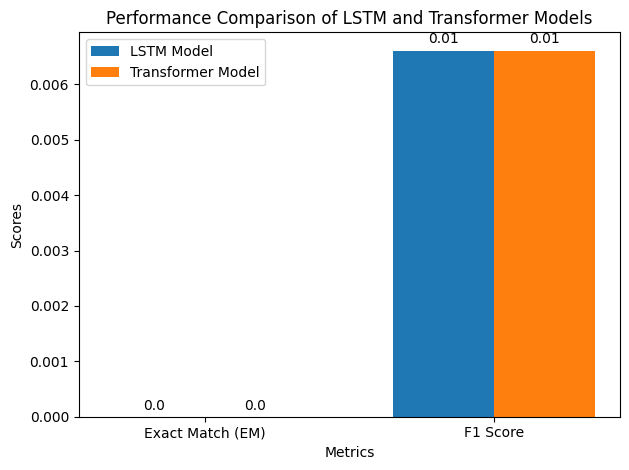

In [ ]:
import matplotlib.pyplot as plt

# Define the scores
metrics = ['Exact Match (EM)', 'F1 Score']
lstm_scores = [em_score_lstm, f1_score_avg_lstm]
transformer_scores = [em_score_transformer, f1_score_avg_transformer]

# Define the position of the bars on the x-axis
x = np.arange(len(metrics))

# Define the width of the bars
width = 0.35

# Create the bar chart
fig, ax = plt.subplots()

bars1 = ax.bar(x - width/2, lstm_scores, width, label='LSTM Model')
bars2 = ax.bar(x + width/2, transformer_scores, width, label='Transformer Model')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of LSTM and Transformer Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Attach a text label above each bar in *bars*, displaying its height
def autolabel(bars):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

fig.tight_layout()

# Display the plot
plt.show()
